# 라이브러리

In [29]:
from google.colab import drive
drive.mount('/content/drive')

!pip install tslearn

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tslearn.clustering import TimeSeriesKMeans

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 데이터 불러오기

- id : 샘플 아이디
- Store : 쇼핑몰 지점
- Date : 주 단위(Weekly) 날짜
- Temperature : 해당 쇼핑몰 주변 기온
- Fuel_Price : 해당 쇼핑몰 주변 연료 가격
- Promotion 1~5 : 해당 쇼핑몰의 비식별화된 프로모션 정보
- Unemployment : 해당 쇼핑몰 지역의 실업률
- IsHoliday : 해당 기간의 공휴일 포함 여부
- Weekly_Sales : 주간 매출액 (목표 예측값)

In [30]:
df = pd.read_csv('/content/drive/MyDrive/프로젝트/쇼핑몰 지점별 매출액 /train.csv')

In [31]:
df

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
0,1,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,8.106,False,1643690.90
1,2,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,8.106,True,1641957.44
2,3,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,8.106,False,1611968.17
3,4,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,8.106,False,1409727.59
4,5,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,8.106,False,1554806.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6250,6251,45,31/08/2012,75.09,3.867,23641.30,6.00,92.93,6988.31,3992.13,8.684,False,734297.87
6251,6252,45,07/09/2012,75.70,3.911,11024.45,12.80,52.63,1854.77,2055.70,8.684,True,766512.66
6252,6253,45,14/09/2012,67.87,3.948,11407.95,NaN,4.30,3421.72,5268.92,8.684,False,702238.27
6253,6254,45,21/09/2012,65.32,4.038,8452.20,92.28,63.24,2376.38,8670.40,8.684,False,723086.20


In [4]:
df.isna().sum()

id                 0
Store              0
Date               0
Temperature        0
Fuel_Price         0
Promotion1      4153
Promotion2      4663
Promotion3      4370
Promotion4      4436
Promotion5      4140
Unemployment       0
IsHoliday          0
Weekly_Sales       0
dtype: int64

In [ ]:
def hist_df(col):
  plt.figure(figsize=(10, 5)) # 가로, 세로 

  plt.hist(df[col], bins = 50)
  plt.title(col, fontsize=15)

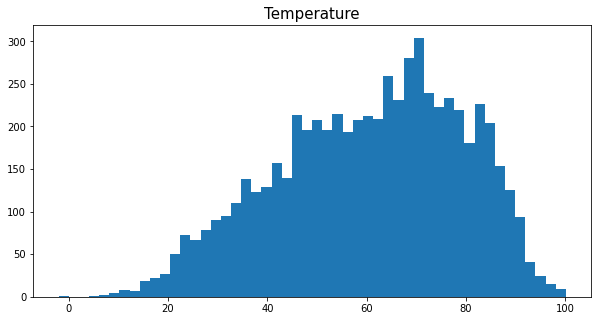

In [ ]:
hist_df('Temperature')

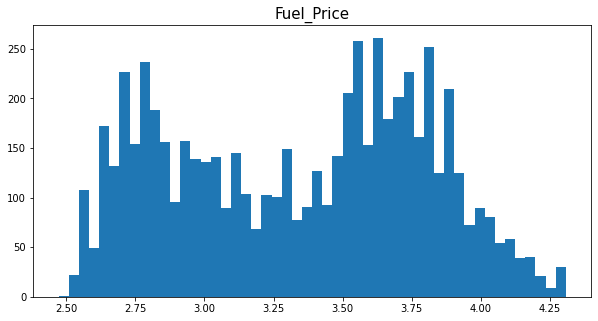

In [ ]:
hist_df('Fuel_Price')

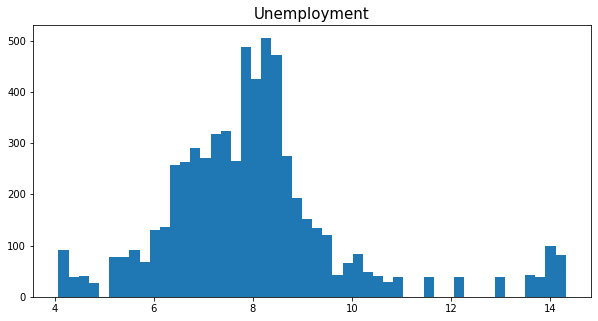

In [ ]:
hist_df('Unemployment')

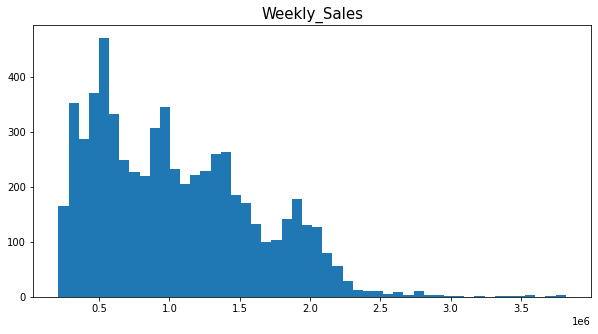

In [ ]:
hist_df('Weekly_Sales')

## IsHoliday: True

In [ ]:
def hist_isholiday_true(col): 
  plt.figure(figsize=(10, 5)) # 가로, 세로 
  x = df[df.IsHoliday == True]

  plt.hist(x[col], bins = 50)
  plt.title(col, fontsize=15)

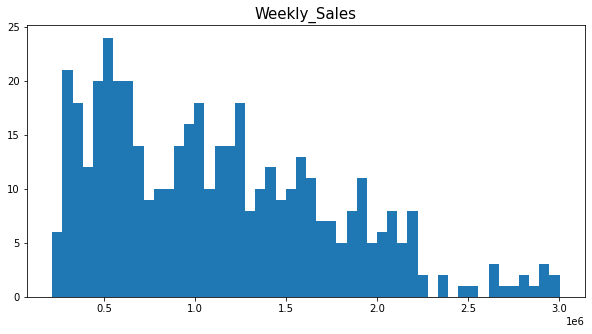

In [ ]:
hist_isholiday_true('Weekly_Sales')

## IsHoliday: False

In [ ]:
def hist_isholiday_false(col): 
  plt.figure(figsize=(10, 5)) # 가로, 세로 
  x = df[df.IsHoliday == False]

  plt.hist(x[col], bins = 50)
  plt.title(col, fontsize=15)

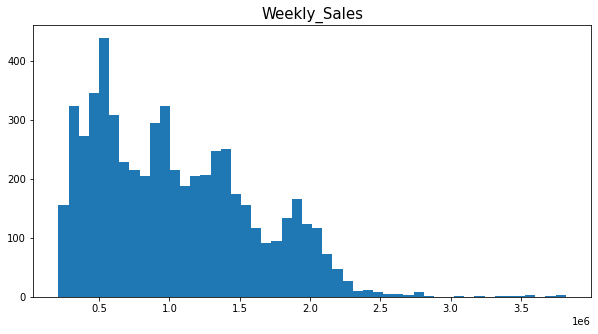

In [ ]:
hist_isholiday_false('Weekly_Sales')

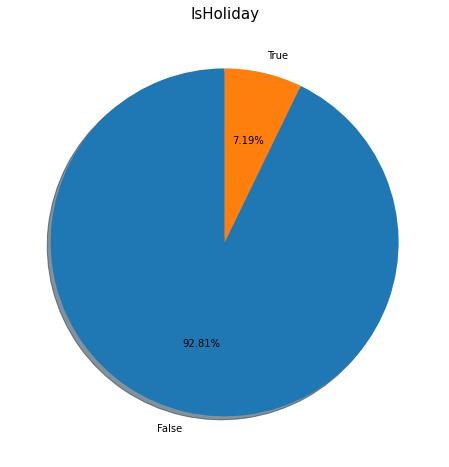

In [ ]:
plt.subplots(figsize = (8,8))
plt.pie(df['IsHoliday'].value_counts(), labels = df['IsHoliday'].value_counts().index, 
        autopct="%.2f%%", shadow = True, startangle = 90)

plt.title('IsHoliday', size=15)
plt.show()

## 시간 순으로 시각화

In [ ]:
def plot_store(col):
  plt.figure(figsize=(25,7))

  x = [i for i in range(0, len(df.Date.unique()), 5)]
  xlabels = df.Date.unique()[x]
  plt.xticks(ticks=x, labels=xlabels, rotation=45)

  plt.xlabel('Date', fontsize = 12)
  plt.ylabel(col, fontsize = 12)
  plt.title(col, size=15)

  for label in df.Store.unique():
    label_df = df[df.Store == label].reset_index(drop = True)
    y = label_df[col]

    plt.plot(y)

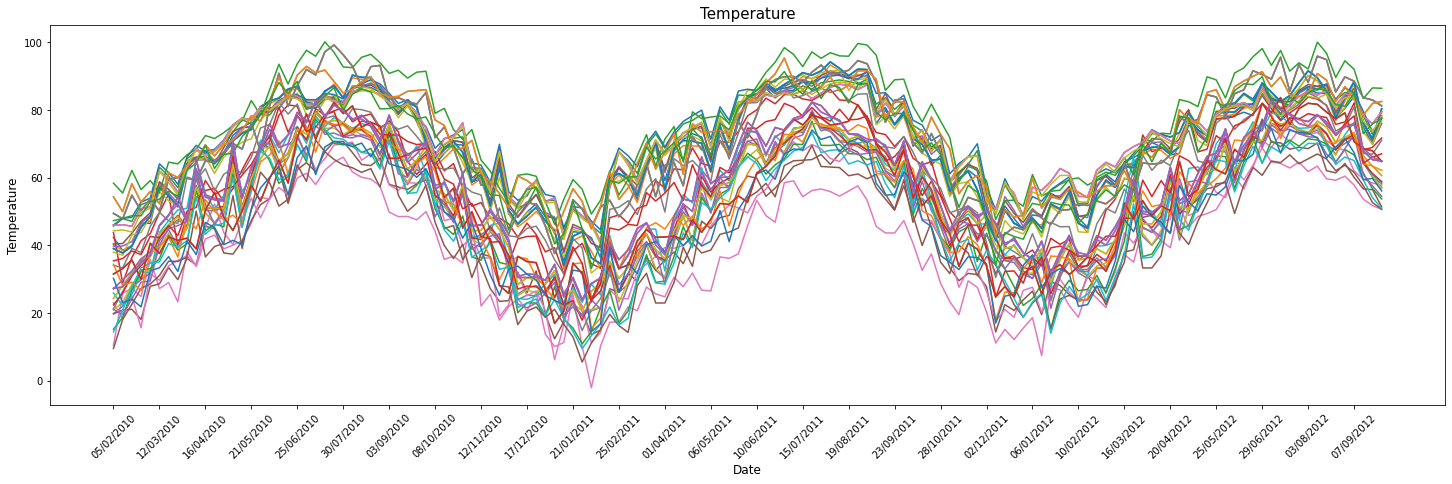

In [ ]:
plot_store('Temperature')

- 비슷한 위치에 있는 쇼핑몰 지점 유추 가능할 것으로 보임 

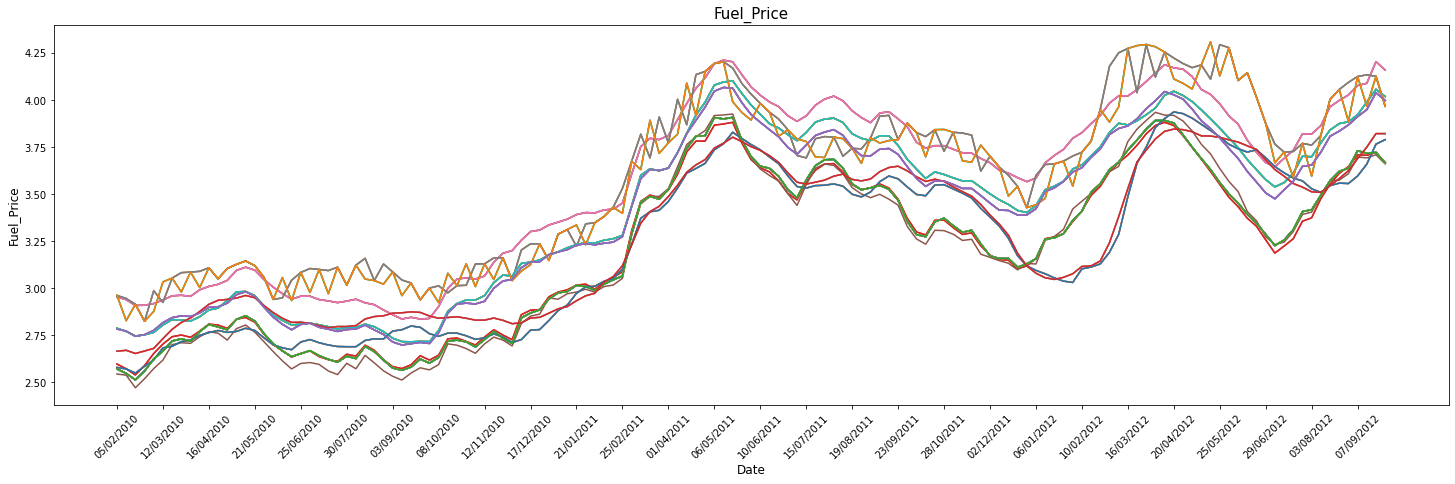

In [ ]:
plot_store('Fuel_Price')

- 11월~12월 사이에 큰 매출을 보임
- 날짜를 이용한 파생변수 사용가능할 것으로 보임  

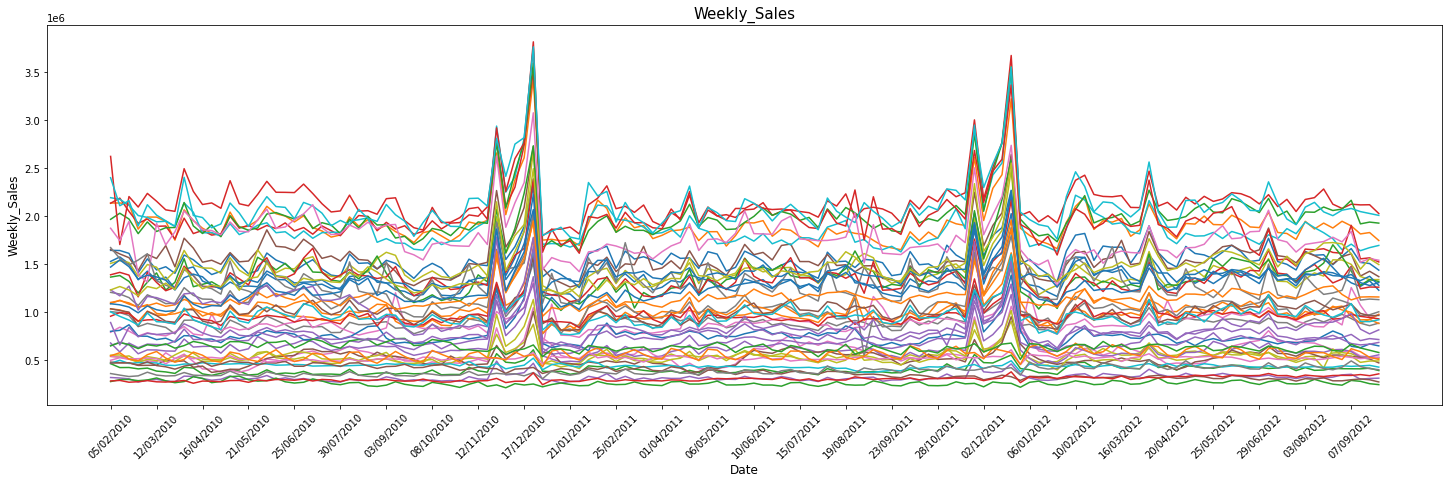

In [ ]:
plot_store('Weekly_Sales')

## 결측치 시각화

In [ ]:
def plot_promotion(col):
  plt.figure(figsize=(25,7))

  x = [i for i in range(0, len(df.Date.unique()), 5)]
  xlabels = df.Date.unique()[x]
  plt.xticks(ticks=x, labels=xlabels, rotation=45)

  plt.xlabel('Date', fontsize = 12)
  plt.ylabel(col, fontsize = 12)
  plt.title(col, size=15)

  for label in df.Store.unique():
    label_df = df[df.Store == label].reset_index(drop = True)
    y = label_df[col].fillna(0)

    plt.plot(y)

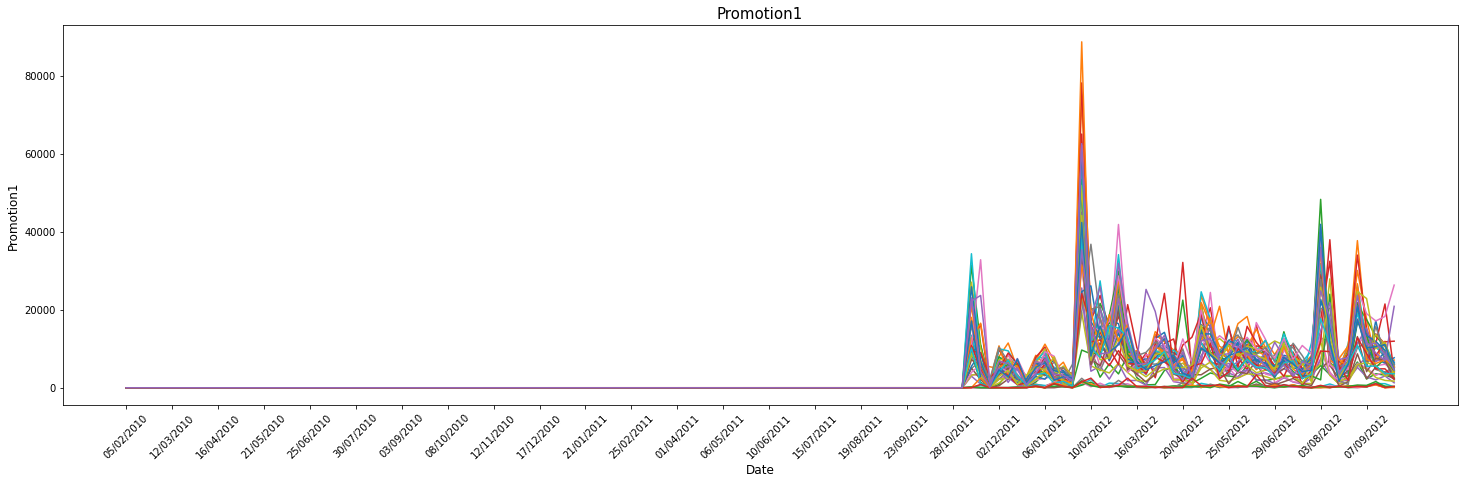

In [ ]:
plot_promotion('Promotion1')

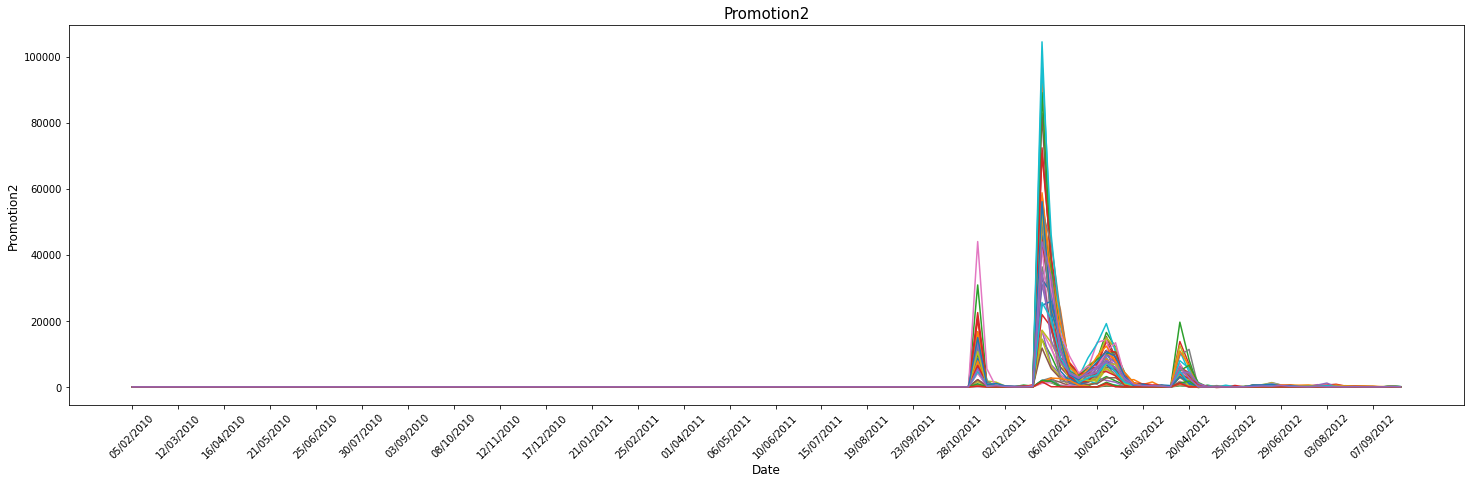

In [ ]:
plot_promotion('Promotion2')

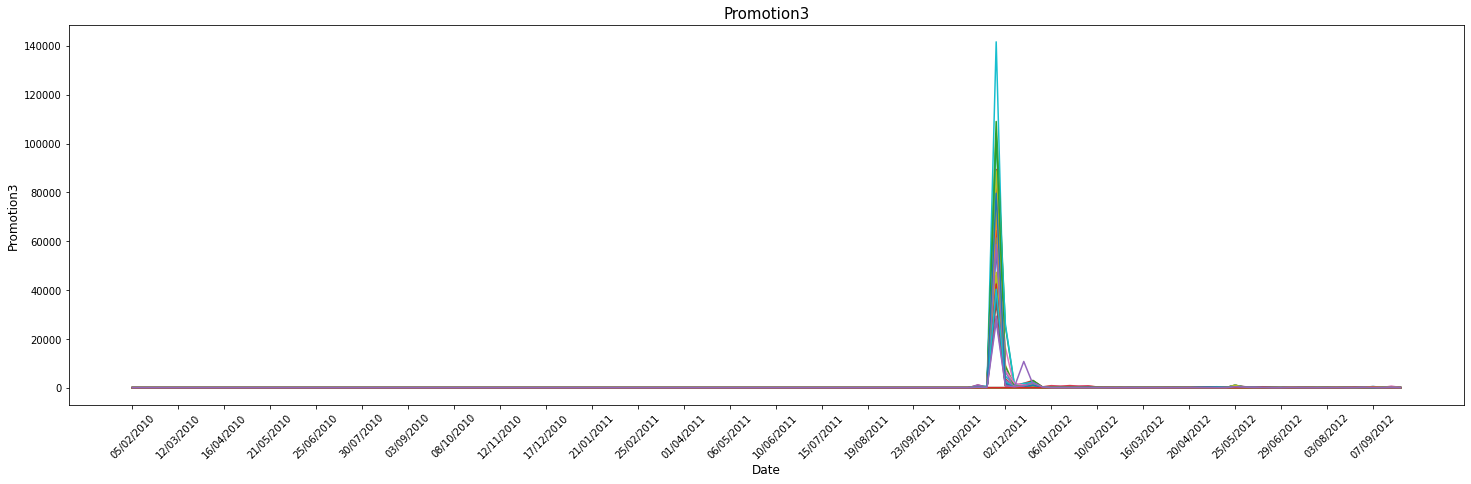

In [ ]:
plot_promotion('Promotion3')

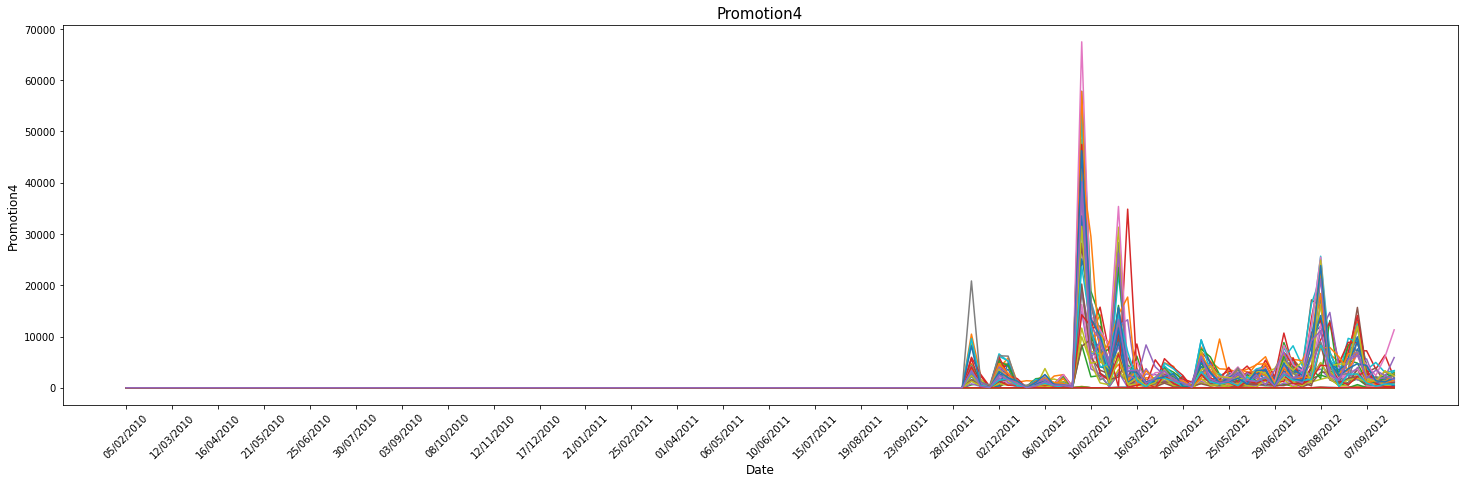

In [ ]:
plot_promotion('Promotion4')

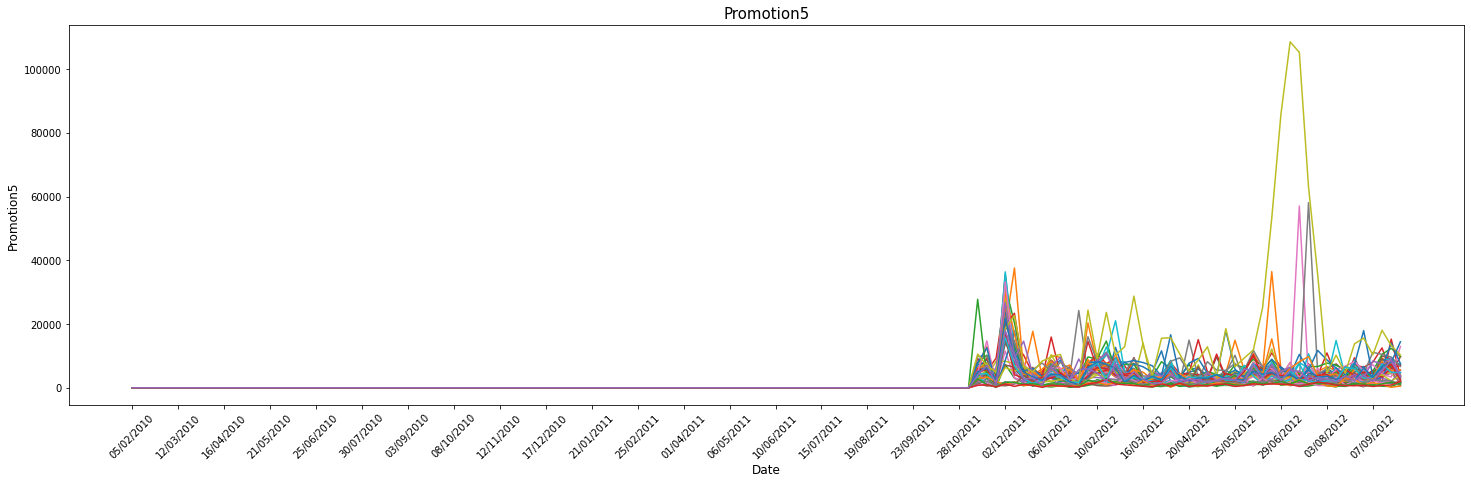

In [ ]:
plot_promotion('Promotion5')

- promotion1~5 결측치 보간 방법: 0으로 대체 
- 시계열 데이터 모델에 input 기간: 과거 데이터 12주 데이터 input 
- 날짜 파생변수 활용 방법: 년,월,일
- 연료 가격 데이터로 비슷한 위치에 존재하는 지점 찾아서 어떤식으로 활용할 수 있을지: 파생 변수용 
- 공부할 내용 정하기 

# 군집화

In [7]:
def create_cluster_data(df, col):
  clustering_df = []   # 군집화 데이터 
  ticker_list = df['Store'].unique()   # 지점 list
  ticker_info_dict = {}

  for ticker in ticker_list:
    ticker_df = df[df['Store'] == ticker]
    ticker_df = ticker_df.loc[:,[col]]  

    clustering_df.append(ticker_df)

  return clustering_df

In [8]:
def MinMax_df(clustering_df):
  for i in range(len(clustering_df)):
      clustering_df[i] = MinMaxScaler().fit_transform(clustering_df[i])
      clustering_df[i]= clustering_df[i].reshape(len(clustering_df[i]))
      
  return clustering_df

In [17]:
def cluter_group(cluter_num):
  cluter_info = []

  for store, label in zip(df['Store'].unique(), labels):
    if label == cluter_num:
      cluter_info.append(store)

  print('Cluter {0} 쇼핑몰 지점: {1}'.format(cluter_num,cluter_info))

# Time Series K-Means: Fuel_Price 

In [9]:
clustering_df = create_cluster_data(df, 'Fuel_Price')

print("군집화 데이터 shape:", np.shape(clustering_df))

군집화 데이터 shape: (45, 139, 1)


In [10]:
clustering_df = MinMax_df(clustering_df)
print("군집화 데이터 shape:", np.shape(clustering_df))

군집화 데이터 shape: (45, 139)


## Elbow Method
- Elbow Method를 사용하여 cluters number 결정

In [11]:
elbow_data = []

for n_clusters in range (1,11,1):
  km = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", verbose=False, random_state=100, n_jobs=-1)
  labels = km.fit_predict(clustering_df)

  elbow_data.append((n_clusters, km.inertia_))

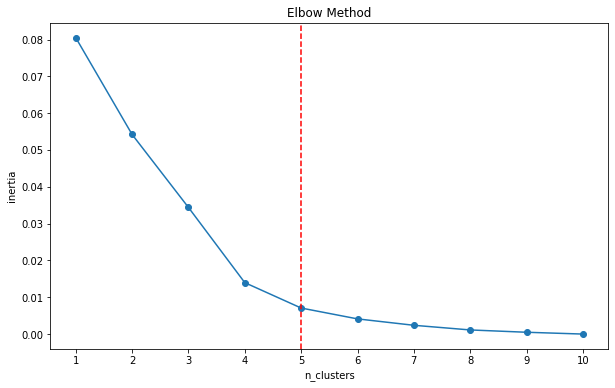

In [12]:
elbow_df = pd.DataFrame(elbow_data, columns=['n_clusters', 'inertia'])

x = elbow_df['n_clusters']
y = elbow_df['inertia']

plt.figure(figsize=(10,6))
plt.plot(x, y, '-o')
plt.title('Elbow Method')
plt.xlabel('n_clusters')
plt.ylabel('inertia')
plt.xticks(x)

plt.axvline(x=5, color='r', linestyle='--')

plt.show()

## Result

In [13]:
km = TimeSeriesKMeans(n_clusters=5, metric="dtw", verbose=False, random_state=100, n_jobs=-1)
labels = km.fit_predict(clustering_df)

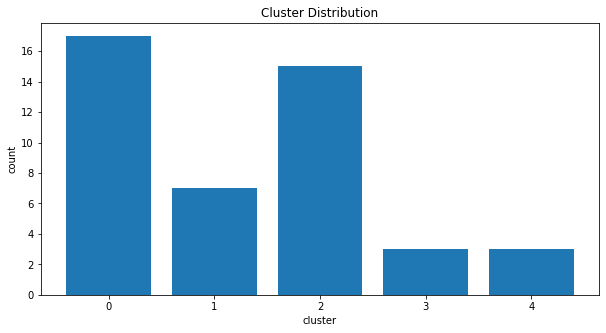

In [14]:
plt.figure(figsize=(10,5))
plt.title("Cluster Distribution")

cluter_count = pd.value_counts(labels).sort_index()
x = cluter_count.index
y = cluter_count.values
plt.bar(x, y)

plt.xlabel('cluster')
plt.ylabel('count')

plt.show()

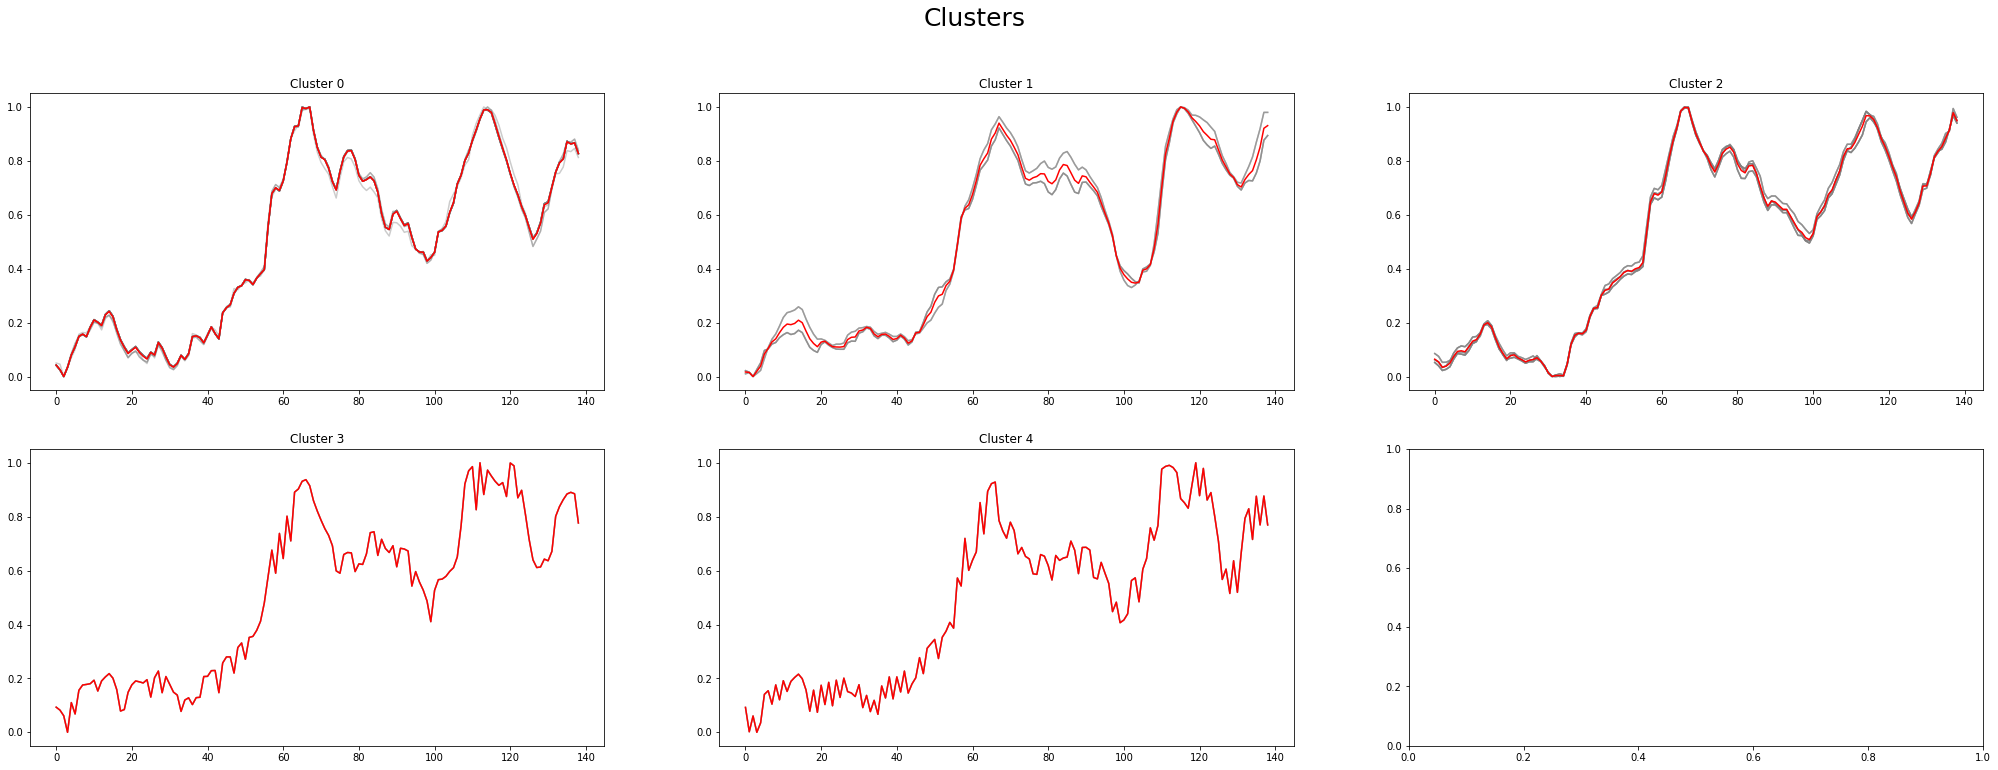

In [15]:
plot_row_count = 2
plot_col_count = 3

fig, axs = plt.subplots(plot_row_count,plot_col_count,figsize=(35,12))
fig.suptitle('Clusters', fontsize=25)

axs_i=0
axs_j=0

for label in set(labels):
  cluster = []
  for i in range(len(labels)):
    if labels[i]==label:
      axs[axs_i, axs_j].plot(clustering_df[i],c="gray",alpha=0.4)
      cluster.append(clustering_df[i])
    
  axs[axs_i, axs_j].plot(np.average(cluster,axis=0),c="red")
  axs[axs_i, axs_j].set_title("Cluster "+str(label))

  axs_j+=1
  if axs_j == plot_col_count:
    axs_j = 0
    axs_i+=1

plt.show()

In [18]:
for i in range(5):
  cluter_group(i)

Cluter 0 쇼핑몰 지점: [1, 2, 3, 4, 5, 6, 8, 9, 11, 21, 30, 31, 34, 36, 37, 39, 43]
Cluter 1 쇼핑몰 지점: [7, 13, 16, 17, 32, 41, 44]
Cluter 2 쇼핑몰 지점: [14, 15, 18, 19, 20, 22, 23, 24, 25, 26, 27, 29, 35, 40, 45]
Cluter 3 쇼핑몰 지점: [12, 28, 38]
Cluter 4 쇼핑몰 지점: [10, 33, 42]


# Time Series K-Means: Weekly_Sales

In [19]:
clustering_df = create_cluster_data(df, 'Weekly_Sales')

print("군집화 데이터 shape:", np.shape(clustering_df))

군집화 데이터 shape: (45, 139, 1)


In [20]:
clustering_df = MinMax_df(clustering_df)
print("군집화 데이터 shape:", np.shape(clustering_df))

군집화 데이터 shape: (45, 139)


## Elbow Method
- Elbow Method를 사용하여 cluters number 결정

In [21]:
elbow_data = []

for n_clusters in range (1,11,1):
  km = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", verbose=False, random_state=100, n_jobs=-1)
  labels = km.fit_predict(clustering_df)

  elbow_data.append((n_clusters, km.inertia_))

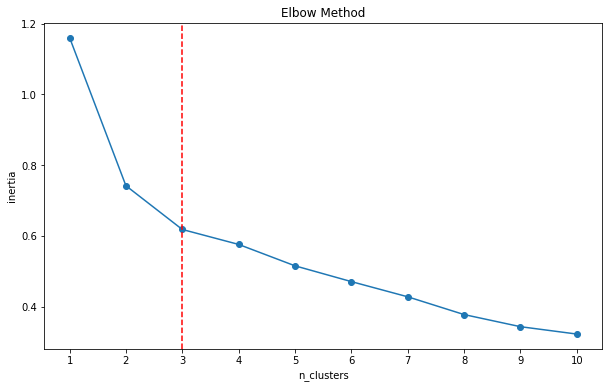

In [23]:
elbow_df = pd.DataFrame(elbow_data, columns=['n_clusters', 'inertia'])

x = elbow_df['n_clusters']
y = elbow_df['inertia']

plt.figure(figsize=(10,6))
plt.plot(x, y, '-o')
plt.title('Elbow Method')
plt.xlabel('n_clusters')
plt.ylabel('inertia')
plt.xticks(x)

plt.axvline(x=3, color='r', linestyle='--')

plt.show()

## Result

In [24]:
km = TimeSeriesKMeans(n_clusters=3, metric="dtw", verbose=False, random_state=100, n_jobs=-1)
labels = km.fit_predict(clustering_df)

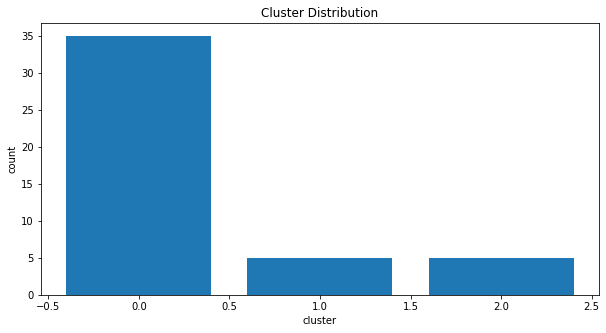

In [25]:
plt.figure(figsize=(10,5))
plt.title("Cluster Distribution")

cluter_count = pd.value_counts(labels).sort_index()
x = cluter_count.index
y = cluter_count.values
plt.bar(x, y)

plt.xlabel('cluster')
plt.ylabel('count')

plt.show()

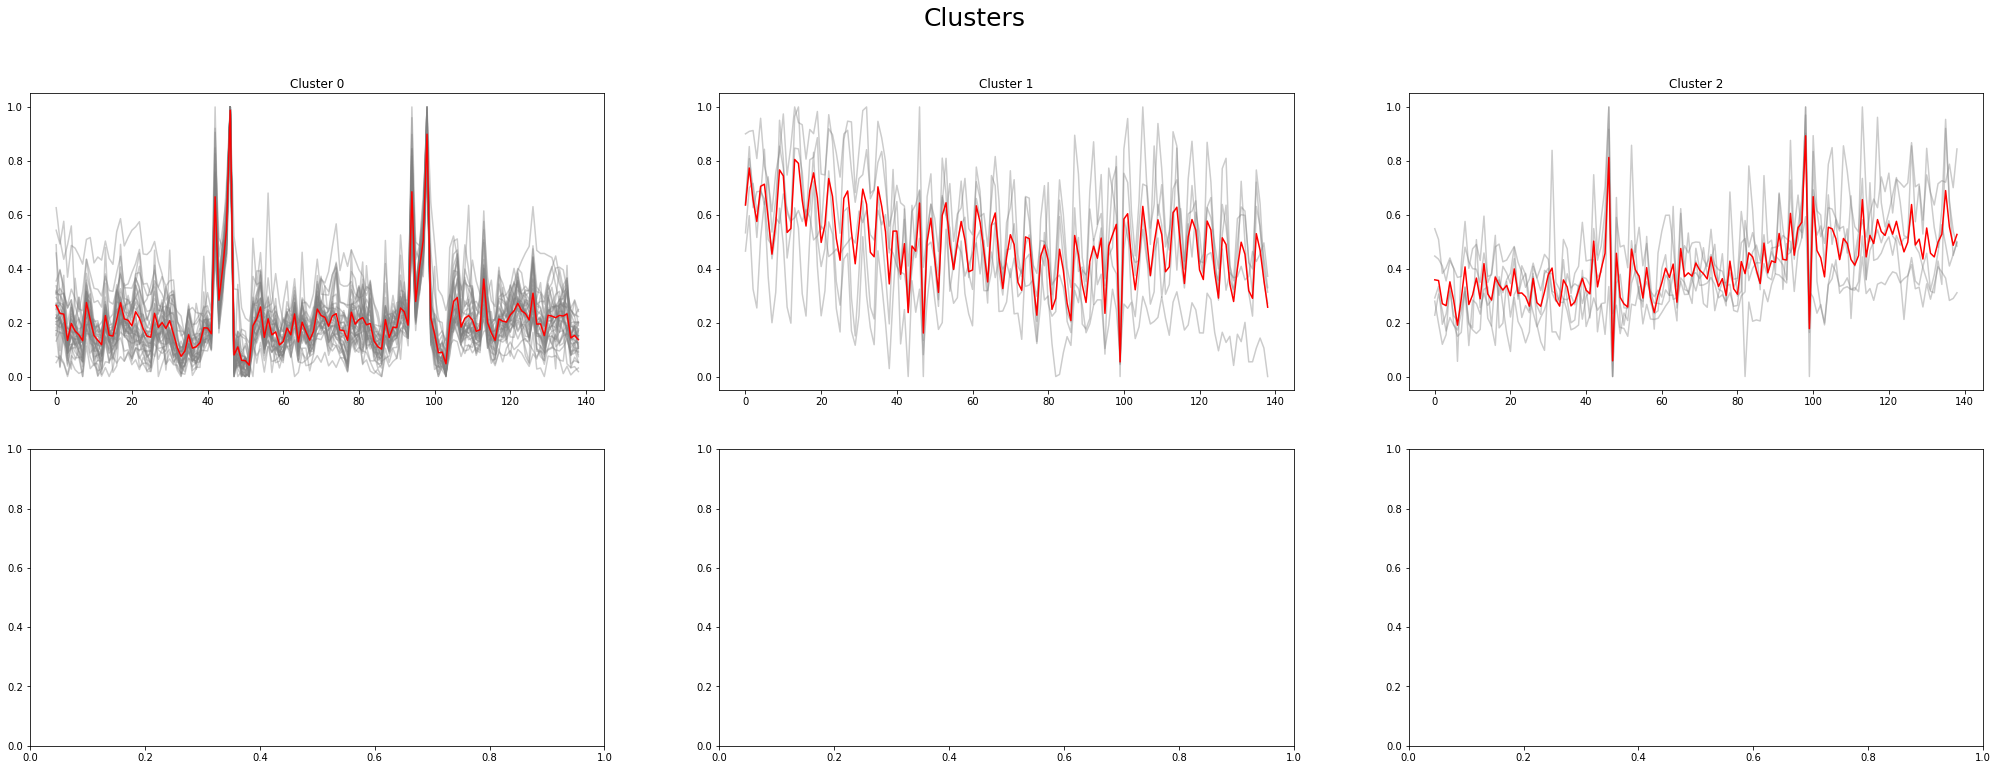

In [33]:
plot_row_count = 2
plot_col_count = 3

fig, axs = plt.subplots(plot_row_count,plot_col_count,figsize=(35,12))
fig.suptitle('Clusters', fontsize=25)

axs_i=0
axs_j=0

for label in set(labels):
  cluster = []
  for i in range(len(labels)):
    if labels[i]==label:
      axs[axs_i, axs_j].plot(clustering_df[i],c="gray",alpha=0.4)
      cluster.append(clustering_df[i])
    
  axs[axs_i, axs_j].plot(np.average(cluster,axis=0),c="red")
  axs[axs_i, axs_j].set_title("Cluster "+str(label))

  axs_j+=1
  if axs_j == plot_col_count:
    axs_j = 0
    axs_i+=1

plt.show()

In [34]:
for i in range(3):
  cluter_group(i)

Cluter 0 쇼핑몰 지점: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 34, 35, 39, 40, 41, 45]
Cluter 1 쇼핑몰 지점: [30, 33, 36, 42, 43]
Cluter 2 쇼핑몰 지점: [17, 18, 37, 38, 44]
